In [1]:
import pandas as pd
import numpy as np
from src import Machine
from src import Job
from src import Operation
from src import Agent
from src import Production_line

from importlib import reload

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))




from pyomo.environ import *
from pyomo.gdp import *

In [2]:
all_machine = ["broyeur_b1" , "broyeur_b2", "tamiseur_b2" , "melangeur_b1" , 
               "melangeur_b2", "extrudeur_b2" , "combinaison_b",
               "millieu_b1" , "perry_b2", "sortie_lyo_b2" , "capsulage_b1",
               "IV_b" , "envoi_irr_g" , "retour_irr_g"]
for i, name in enumerate(all_machine):
    print(i,name)

0 broyeur_b1
1 broyeur_b2
2 tamiseur_b2
3 melangeur_b1
4 melangeur_b2
5 extrudeur_b2
6 combinaison_b
7 millieu_b1
8 perry_b2
9 sortie_lyo_b2
10 capsulage_b1
11 IV_b
12 envoi_irr_g
13 retour_irr_g


In [3]:
TASKS = {
    ('lot1' , 'broyeur')   : {'dur': 2, 'prec': None},
    ('lot1', 'tamiseur') : {'dur': 1, 'prec': ('lot1' , 'broyeur')},
    ('lot1', 'mélangeur')   : {'dur': 1, 'prec': ('lot1', 'tamiseur')},
    ('lot1', 'extrudeur')  : {'dur': 2, 'prec': ('lot1', 'mélangeur')},
    ('lot1', 'broyeur_ug') : {'dur': 4, 'prec': ('lot1', 'extrudeur')},
    ('lot1', 'tamiseur_ug')   : {'dur': 2, 'prec': ('lot1', 'broyeur_ug')},
    ('lot1', 'tween')  : {'dur': 3, 'prec': ('lot1', 'tamiseur_ug')},
    ('lot1', 'remplisseuse') : {'dur': 4, 'prec': {('lot1', 'tamiseur_ug'),('lot1', 'tween')}},   
    ('lot1', 'sortie_lyo') : {'dur': 1, 'prec': ('lot1', 'remplisseuse')},  
    ('lot1', 'capsulage') : {'dur': 2, 'prec': ('lot1', 'sortie_lyo')},  
    ('lot1', 'IV') : {'dur': 4, 'prec': ('lot1', 'capsulage')},  
    ('lot1', 'Envoi IR') : {'dur': 1, 'prec': ('lot1', 'IV')},  
    ('lot1', 'retour IR ') : {'dur': 1, 'prec': ('lot1', 'Envoi IR')},
    
    ('lot2' , 'broyeur')   : {'dur': 2, 'prec': None},
    ('lot2', 'tamiseur') : {'dur': 1, 'prec': ('lot2' , 'broyeur')},
    ('lot2', 'mélangeur')   : {'dur': 1, 'prec': ('lot2', 'tamiseur')},
    ('lot2', 'extrudeur')  : {'dur': 2, 'prec': ('lot2', 'mélangeur')},
    ('lot2', 'broyeur_ug') : {'dur': 4, 'prec': ('lot2', 'extrudeur')},
    ('lot2', 'tamiseur_ug')   : {'dur': 2, 'prec': ('lot2', 'broyeur_ug')},
    ('lot2', 'tween')  : {'dur': 3, 'prec': ('lot2', 'tamiseur_ug')},
    ('lot2', 'remplisseuse') : {'dur': 4, 'prec': ('lot2', 'tamiseur_ug')},   
    ('lot2', 'sortie_lyo') : {'dur': 1, 'prec': ('lot2', 'remplisseuse')},  
    ('lot2', 'capsulage') : {'dur': 2, 'prec': ('lot2', 'sortie_lyo')},  
    ('lot2', 'IV') : {'dur': 4, 'prec': ('lot2', 'capsulage')},  
    ('lot2', 'Envoi IR') : {'dur': 1, 'prec': ('lot2', 'IV')},  
    ('lot2', 'retour IR ') : {'dur': 1, 'prec': ('lot2', 'Envoi IR')},  
    
    ('lot3' , 'broyeur')   : {'dur': 2, 'prec': None},
    ('lot3', 'tamiseur') : {'dur': 1, 'prec': ('lot3' , 'broyeur')},
    ('lot3', 'mélangeur')   : {'dur': 1, 'prec': ('lot3', 'tamiseur')},
    ('lot3', 'extrudeur')  : {'dur': 2, 'prec': ('lot3', 'mélangeur')},
    ('lot3', 'broyeur_ug') : {'dur': 4, 'prec': ('lot3', 'extrudeur')},
    ('lot3', 'tamiseur_ug')   : {'dur': 2, 'prec': ('lot3', 'broyeur_ug')},
    ('lot3', 'tween')  : {'dur': 3, 'prec': ('lot3', 'tamiseur_ug')},
    ('lot3', 'remplisseuse') : {'dur': 4, 'prec': ('lot3', 'tamiseur_ug')},   
    ('lot3', 'sortie_lyo') : {'dur': 1, 'prec': ('lot3', 'remplisseuse')},  
    ('lot3', 'capsulage') : {'dur': 2, 'prec': ('lot3', 'sortie_lyo')},  
    ('lot3', 'IV') : {'dur': 4, 'prec': ('lot3', 'capsulage')},  
    ('lot3', 'Envoi IR') : {'dur': 1, 'prec': ('lot3', 'IV')},  
    ('lot3', 'retour IR ') : {'dur': 1, 'prec': ('lot3', 'Envoi IR')},  
}

In [4]:
def jobshop_model(TASKS):
    
    model = ConcreteModel()

    # tasks is a two dimensional set of (j,m) constructed from the dictionary keys
    model.TASKS = Set(initialize = TASKS.keys(), dimen=2)
    
    # the set of jobs is constructed from a python set
    model.JOBS = Set(initialize = list(set([j for (j,m) in model.TASKS])))
    
    # set of machines is constructed from a python set
    model.MACHINES = Set(initialize = list(set([m for (j,m) in model.TASKS])))
    
    # the order of tasks is constructed as a cross-product of tasks and filtering
    model.TASKORDER = Set(initialize = model.TASKS * model.TASKS, dimen=4, 
        filter = lambda model, j, m, k, n: (k,n) == TASKS[(j,m)]['prec'])
    
    # the set of disjunctions is cross-product of jobs, jobs, and machines
    model.DISJUNCTIONS = Set(initialize = model.JOBS * model.JOBS * model.MACHINES, dimen=3,
        filter = lambda model, j, k, m: j < k and (j,m) in model.TASKS and (k,m) in model.TASKS)
    
    # load duration data into a model parameter for later access
    model.dur = Param(model.TASKS, initialize=lambda model, j, m: TASKS[(j,m)]['dur'])

    # establish an upper bound on makespan
    ub = sum([model.dur[j, m] for (j,m) in model.TASKS])
    
    # create decision variables
    model.makespan = Var(bounds=(0, ub))
    model.start = Var(model.TASKS, bounds=(0, ub))
    
    model.objective = Objective(expr = model.makespan, sense = minimize)

    model.finish = Constraint(model.TASKS, rule=lambda model, j, m:  
        model.start[j,m] + model.dur[j,m] <= model.makespan)
    
    model.preceding = Constraint(model.TASKORDER, rule=lambda model, j, m, k, n: 
        model.start[k,n] + model.dur[k,n] <= model.start[j,m])
    
    model.disjunctions = Disjunction(model.DISJUNCTIONS, rule=lambda model,j,k,m:
        [model.start[j,m] + model.dur[j,m] <= model.start[k,m], 
         model.start[k,m] + model.dur[k,m] <= model.start[j,m]])
    
    TransformationFactory('gdp.hull').apply_to(model)
    return model

jobshop_model(TASKS)

In [5]:
def jobshop_solve(model):
    SolverFactory('glpk').solve(model)
    results = [{'Job': j,
                'Machine': m,
                'Start': model.start[j, m](), 
                'Duration': model.dur[j,m], 
                'Finish': model.start[(j, m)]() + model.dur[j,m]}
               for j,m in model.TASKS]
    return results

def jobshop(TASKS):
    return jobshop_solve(jobshop_model(TASKS))

results = jobshop(TASKS)
results

[{'Job': 'lot1',
  'Machine': 'broyeur',
  'Start': 8.0,
  'Duration': 2,
  'Finish': 10.0},
 {'Job': 'lot1',
  'Machine': 'tamiseur',
  'Start': 10.0,
  'Duration': 1,
  'Finish': 11.0},
 {'Job': 'lot1',
  'Machine': 'mélangeur',
  'Start': 11.0,
  'Duration': 1,
  'Finish': 12.0},
 {'Job': 'lot1',
  'Machine': 'extrudeur',
  'Start': 12.0,
  'Duration': 2,
  'Finish': 14.0},
 {'Job': 'lot1',
  'Machine': 'broyeur_ug',
  'Start': 14.0,
  'Duration': 4,
  'Finish': 18.0},
 {'Job': 'lot1',
  'Machine': 'tamiseur_ug',
  'Start': 18.0,
  'Duration': 2,
  'Finish': 20.0},
 {'Job': 'lot1',
  'Machine': 'tween',
  'Start': 20.0,
  'Duration': 3,
  'Finish': 23.0},
 {'Job': 'lot1',
  'Machine': 'remplisseuse',
  'Start': 0.0,
  'Duration': 4,
  'Finish': 4.0},
 {'Job': 'lot1',
  'Machine': 'sortie_lyo',
  'Start': 4.0,
  'Duration': 1,
  'Finish': 5.0},
 {'Job': 'lot1',
  'Machine': 'capsulage',
  'Start': 5.0,
  'Duration': 2,
  'Finish': 7.0},
 {'Job': 'lot1', 'Machine': 'IV', 'Start': 7.0,

In [6]:
schedule = pd.DataFrame(results)

print('\nSchedule by Job')
print(schedule.sort_values(by=['Job','Start']).set_index(['Job', 'Machine']))

print('\nSchedule by Machine')
print(schedule.sort_values(by=['Machine','Start']).set_index(['Machine', 'Job']))


Schedule by Job
                   Start  Duration  Finish
Job  Machine                              
lot1 remplisseuse    0.0         4     4.0
     sortie_lyo      4.0         1     5.0
     capsulage       5.0         2     7.0
     IV              7.0         4    11.0
     broyeur         8.0         2    10.0
     tamiseur       10.0         1    11.0
     mélangeur      11.0         1    12.0
     extrudeur      12.0         2    14.0
     broyeur_ug     14.0         4    18.0
     tamiseur_ug    18.0         2    20.0
     tween          20.0         3    23.0
     Envoi IR       24.0         1    25.0
     retour IR      25.0         1    26.0
lot2 broyeur         4.0         2     6.0
     tamiseur        6.0         1     7.0
     mélangeur       7.0         1     8.0
     extrudeur       8.0         2    10.0
     broyeur_ug     10.0         4    14.0
     tamiseur_ug    14.0         2    16.0
     tween          16.0         3    19.0
     remplisseuse   16.0         4   

     Job       Machine  Start  Duration  Finish
0   lot1       broyeur    8.0         2    10.0
1   lot1      tamiseur   10.0         1    11.0
2   lot1     mélangeur   11.0         1    12.0
3   lot1     extrudeur   12.0         2    14.0
4   lot1    broyeur_ug   14.0         4    18.0
5   lot1   tamiseur_ug   18.0         2    20.0
6   lot1         tween   20.0         3    23.0
7   lot1  remplisseuse    0.0         4     4.0
8   lot1    sortie_lyo    4.0         1     5.0
9   lot1     capsulage    5.0         2     7.0
10  lot1            IV    7.0         4    11.0
11  lot1      Envoi IR   24.0         1    25.0
12  lot1    retour IR    25.0         1    26.0
13  lot2       broyeur    4.0         2     6.0
14  lot2      tamiseur    6.0         1     7.0
15  lot2     mélangeur    7.0         1     8.0
16  lot2     extrudeur    8.0         2    10.0
17  lot2    broyeur_ug   10.0         4    14.0
18  lot2   tamiseur_ug   14.0         2    16.0
19  lot2         tween   16.0         3 

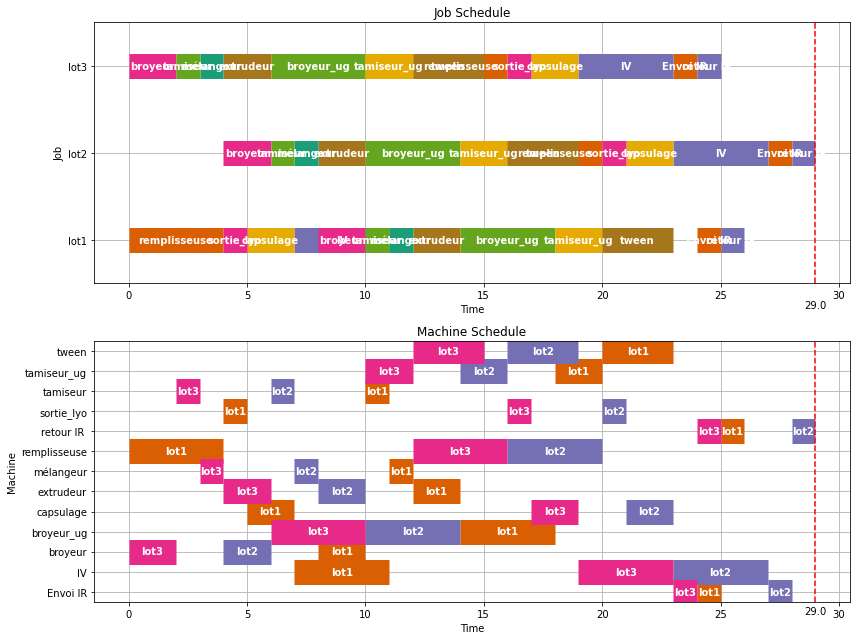

In [8]:
def visualize(results):
    
    schedule = pd.DataFrame(results)
    print(schedule)
    JOBS = sorted(list(schedule['Job'].unique()))
    MACHINES = sorted(list(schedule['Machine'].unique()))
    makespan = schedule['Finish'].max()
    
    bar_style = {'alpha':1.0, 'lw':25, 'solid_capstyle':'butt'}
    text_style = {'color':'white', 'weight':'bold', 'ha':'center', 'va':'center'}
    colors = mpl.cm.Dark2.colors

    schedule.sort_values(by=['Job', 'Start'])
    schedule.set_index(['Job', 'Machine'], inplace=True)
    print(schedule)
    
    print(JOBS)
    print(MACHINES)
    
    fig, ax = plt.subplots(2,1, figsize=(12, 5+(len(JOBS)+len(MACHINES))/4))

    for jdx, j in enumerate(JOBS, 1):
        for mdx, m in enumerate(MACHINES, 1):
            if (j,m) in schedule.index:
                xs = schedule.loc[(j,m), 'Start']
                xf = schedule.loc[(j,m), 'Finish']
                ax[0].plot([xs, xf], [jdx]*2, c=colors[mdx%7], **bar_style)
                ax[0].text((xs + xf)/2, jdx, m, **text_style)
                ax[1].plot([xs, xf], [mdx]*2, c=colors[jdx%7], **bar_style)
                ax[1].text((xs + xf)/2, mdx, j, **text_style)
                
    ax[0].set_title('Job Schedule')
    ax[0].set_ylabel('Job')
    ax[1].set_title('Machine Schedule')
    ax[1].set_ylabel('Machine')
    
    for idx, s in enumerate([JOBS, MACHINES]):
        ax[idx].set_ylim(0.5, len(s) + 0.5)
        ax[idx].set_yticks(range(1, 1 + len(s)))
        ax[idx].set_yticklabels(s)
        ax[idx].text(makespan, ax[idx].get_ylim()[0]-0.2, "{0:0.1f}".format(makespan), ha='center', va='top')
        ax[idx].plot([makespan]*2, ax[idx].get_ylim(), 'r--')
        ax[idx].set_xlabel('Time')
        ax[idx].grid(True)
        
    fig.tight_layout()

visualize(results)